# 0.0 Imports

In [ ]:
# !pip install inflection

In [ ]:
import inflection
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn import model_selection as ms
from sklearn.metrics import accuracy_score, classification_report,precision_score
from sklearn               import model_selection as ms
from sklearn               import ensemble        as en
from sklearn               import neighbors       as nh

In [ ]:
test_data = pd.read_csv('/data/test.csv')
train_data = pd.read_csv('/data/train.csv')

X = train_data.drop(columns=['Satisfaction'])
y = train_data['Satisfaction'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=42)

df1 = pd.concat([x_train, y_train],axis=1)

In [ ]:
def notebook_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,10]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

notebook_settings()

# 1.0 Descrição dos dados

In [ ]:
df1.head()

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,...,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
20921,37164,Female,Loyal Customer,59,Personal,Medium,1046,4,5,4,...,2,2,4,3,5,2,4,12,3.000,Neutral or Dissatisfaction
36897,43436,Female,disloyal Customer,40,Gift,Large,752,4,4,4,...,1,4,2,4,3,5,1,19,29.000,Neutral or Dissatisfaction
8468,5306,Male,Loyal Customer,65,Personal,Medium,383,2,3,2,...,1,5,4,5,5,5,1,0,0.000,Neutral or Dissatisfaction
53490,79161,Female,Loyal Customer,70,Personal,Medium,2239,3,5,3,...,5,5,3,5,3,5,5,0,0.000,Neutral or Dissatisfaction
78687,33333,Female,disloyal Customer,25,Gift,Medium,1358,2,2,2,...,1,1,2,3,5,2,1,3,15.000,Neutral or Dissatisfaction


In [ ]:
df1.shape

(83123, 24)

In [ ]:
# train data
old_cols = df1.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
new_cols = list(map(snakecase, old_cols))
df1.columns = new_cols

# val data
old_cols = x_val.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
new_cols = list(map(snakecase, old_cols))
x_val.columns = new_cols

# test data
old_cols = test_data.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
new_cols = list(map(snakecase, old_cols))
test_data.columns = new_cols

- Store distance - se refere a distância do cliente para a loja ou a distância da loja concorrente mais próxima

- InStore wifi - Corresponde ao número de roteador? Validar essa hipótese comparando com o tamanho da loja.

 Também pode ser a qualidade do wifi, se for então deverá ter muitos dados dispersos.

- Ter uma descrição das colunas com base no conhecimento de negocio de loja de roupas

- Self-store: poderia ser um painel para auto-atendimento

In [ ]:
df1.isna().sum()

id                              0
gender                          0
customer_type                   0
age                             0
type_of_purchase                0
store_size                      0
store_distance                  0
instore_wifi                    0
open_close_time_convenient      0
easy_of_online_shopping         0
store_location                  0
toilet_cleaning                 0
dressing_room                   0
waiting_room                    0
kids_entertainment              0
seller_service                  0
showroom                        0
self-store                      0
purchase_service                0
store_service                   0
cleanliness                     0
carrier_delay_in_minutes        0
delivery_delay_in_minutes     251
satisfaction                    0
dtype: int64

- Hip 1: Quem não preencheu Delivery delay in minutes foi porque comprou em loja física

- Hip 2: Quem não preencheu Delivery delay in minutes foi porque estava insatisfeito

In [ ]:
# train data
df1['delivery_delay_in_minutes'] = df1['delivery_delay_in_minutes'].fillna(0)

# val data
x_val['delivery_delay_in_minutes'] = x_val['delivery_delay_in_minutes'].fillna(0)

# test data
test_data['delivery_delay_in_minutes'] = test_data['delivery_delay_in_minutes'].fillna(0)

In [ ]:
df1.dtypes

id                              int64
gender                         object
customer_type                  object
age                             int64
type_of_purchase               object
store_size                     object
store_distance                  int64
instore_wifi                    int64
open_close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self-store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes        int64
delivery_delay_in_minutes     float64
satisfaction                   object
dtype: object

In [ ]:
df1['delivery_delay_in_minutes'] = df1['delivery_delay_in_minutes'].astype('int64')

x_val['delivery_delay_in_minutes'] = x_val['delivery_delay_in_minutes'].astype('int64')

test_data['delivery_delay_in_minutes'] = test_data['delivery_delay_in_minutes'].astype('int64')

In [ ]:
numerical_attributes = df1.select_dtypes(include='number')
categorical_attributes = df1.select_dtypes(exclude='number')

# Central tendency and Dispersion
d1 = pd.DataFrame (numerical_attributes.apply( lambda x: x.max() - x.min() )).T
d2 = numerical_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concatenate
metrics = pd.concat([d1, d2]).T.reset_index()
metrics.columns = ['attibutes', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics = metrics[['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

metrics

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.000,129879.000,129878.000,65059.540,65078.000,37425.968,-0.002,-1.197
1,age,7.000,85.000,78.000,39.341,40.000,15.124,0.001,-0.722
2,store_distance,31.000,4983.000,4952.000,1188.665,842.000,996.941,1.110,0.271
3,instore_wifi,0.000,5.000,5.000,2.730,3.000,1.328,0.037,-0.846
4,open_close_time_convenient,0.000,5.000,5.000,3.058,3.000,1.527,-0.333,-1.041
5,easy_of_online_shopping,0.000,5.000,5.000,2.759,3.000,1.399,-0.021,-0.909
6,store_location,0.000,5.000,5.000,2.978,3.000,1.277,-0.059,-1.027
7,toilet_cleaning,0.000,5.000,5.000,3.201,3.000,1.328,-0.150,-1.143
8,dressing_room,0.000,5.000,5.000,3.247,3.000,1.349,-0.451,-0.704
9,waiting_room,0.000,5.000,5.000,3.436,4.000,1.319,-0.478,-0.930


In [ ]:
categorical_attributes.apply( lambda x: x.unique().shape[0])

gender              2
customer_type       2
type_of_purchase    2
store_size          3
satisfaction        2
dtype: int64

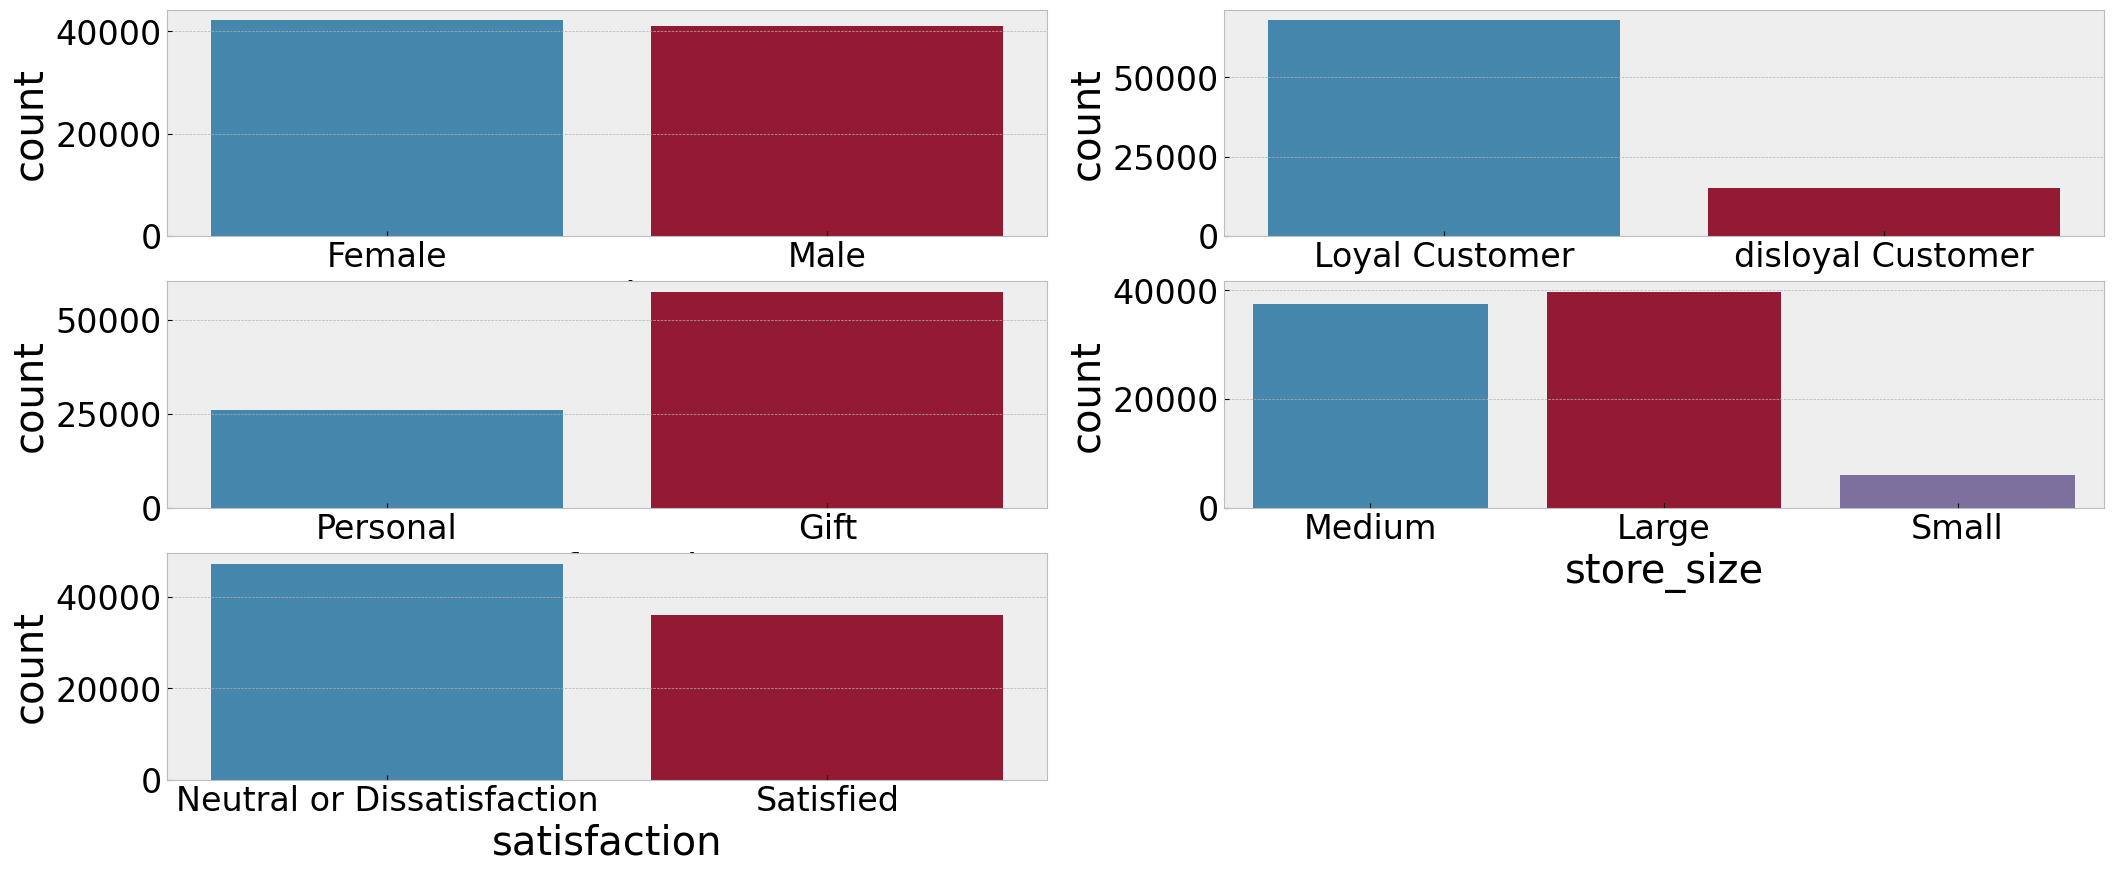

In [ ]:
plt.subplot(3, 2, 1)
sns.countplot(x='gender', data=categorical_attributes)

plt.subplot(3, 2, 2)
sns.countplot(x='customer_type', data=categorical_attributes)

plt.subplot(3, 2, 3)
sns.countplot(x='type_of_purchase', data=categorical_attributes)

plt.subplot(3, 2, 4)
sns.countplot(x='store_size', data=categorical_attributes)

plt.subplot(3, 2, 5)
sns.countplot(x='satisfaction', data=categorical_attributes);

- verificar metragem padrão dos eua para store_distance afim de validar os valores máximos.

# 2.0 Feature Engineering

In [ ]:
df2 = df1.copy()

# 3.0 Filtragem de variáveis

In [ ]:
df3 = df2.copy()

# 4.0 Análise exploratória dos dados

In [ ]:
df4 = df3.copy()

#Ter uma descrição das colunas com base no conhecimento de negocio de loja de roupas

#Store distance - se refere a distância do cliente para a loja ou a distância da loja concorrente mais próxima

#InStore wifi - Corresponde ao número de roteador? Validar essa hipótese comparando com o tamanho da loja.
#Também pode ser a qualidade do wifi, se for então deverá ter muitos dados dispersos.


#Self-store: poderia ser um painel para auto-atendimento

# Delivery_delay
#Hip 1: Quem não preencheu Delivery delay in minutes foi porque comprou em loja física
#Hip 2: Quem não preencheu Delivery delay in minutes foi porque estava insatisfeito

# Store_distance
#verificar metragem padrão dos eua para store_distance afim de validar os valores máximos.



In [ ]:
#InStore wifi - Corresponde ao número de roteador? Validar essa hipótese comparando com o tamanho da loja.
#Também pode ser a qualidade do wifi, se for então deverá ter muitos dados dispersos.
import plotly.express as px
cols = ["store_size","instore_wifi"]
df_aux = df4.loc[:,cols].groupby("store_size").mean().reset_index()
fig = px.pie(df_aux, values = "instore_wifi", names ="store_size")
fig

df_aux1 = df4.loc[:,cols].groupby("instore_wifi").nunique().reset_index()
df_aux1.head()
fig

#aparentemente é a avaliação do wifi 


# 5.0 Preparação dos dados

In [ ]:
df5 = df4.copy()

In [ ]:
# # divisão de dados
# from sklearn.model_selection import train_test_split

# X = df5.drop(['satisfaction'], axis=1)
# y = df5['satisfaction'].copy()

# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42 )

In [ ]:
le = LabelEncoder()

df5['gender'] = le.fit_transform( df5['gender'] )
x_val['gender'] = le.transform( x_val['gender'] )
test_data['gender'] = le.transform( test_data['gender'] )

df5['customer_type'] = le.fit_transform( df5['customer_type'] )
x_val['customer_type'] = le.transform( x_val['customer_type'] )
test_data['customer_type'] = le.transform( test_data['customer_type'] )

df5['type_of_purchase'] = le.fit_transform( df5['type_of_purchase'] )
x_val['type_of_purchase'] = le.transform( x_val['type_of_purchase'] )
test_data['type_of_purchase'] = le.transform( test_data['type_of_purchase'] )

df5['store_size'] = le.fit_transform( df5['store_size'] )
x_val['store_size'] = le.transform( x_val['store_size'] )
test_data['store_size'] = le.transform( test_data['store_size'] )

df5['satisfaction'] = le.fit_transform( df5['satisfaction'] )
y_val = le.transform( y_val )

<AxesSubplot: >

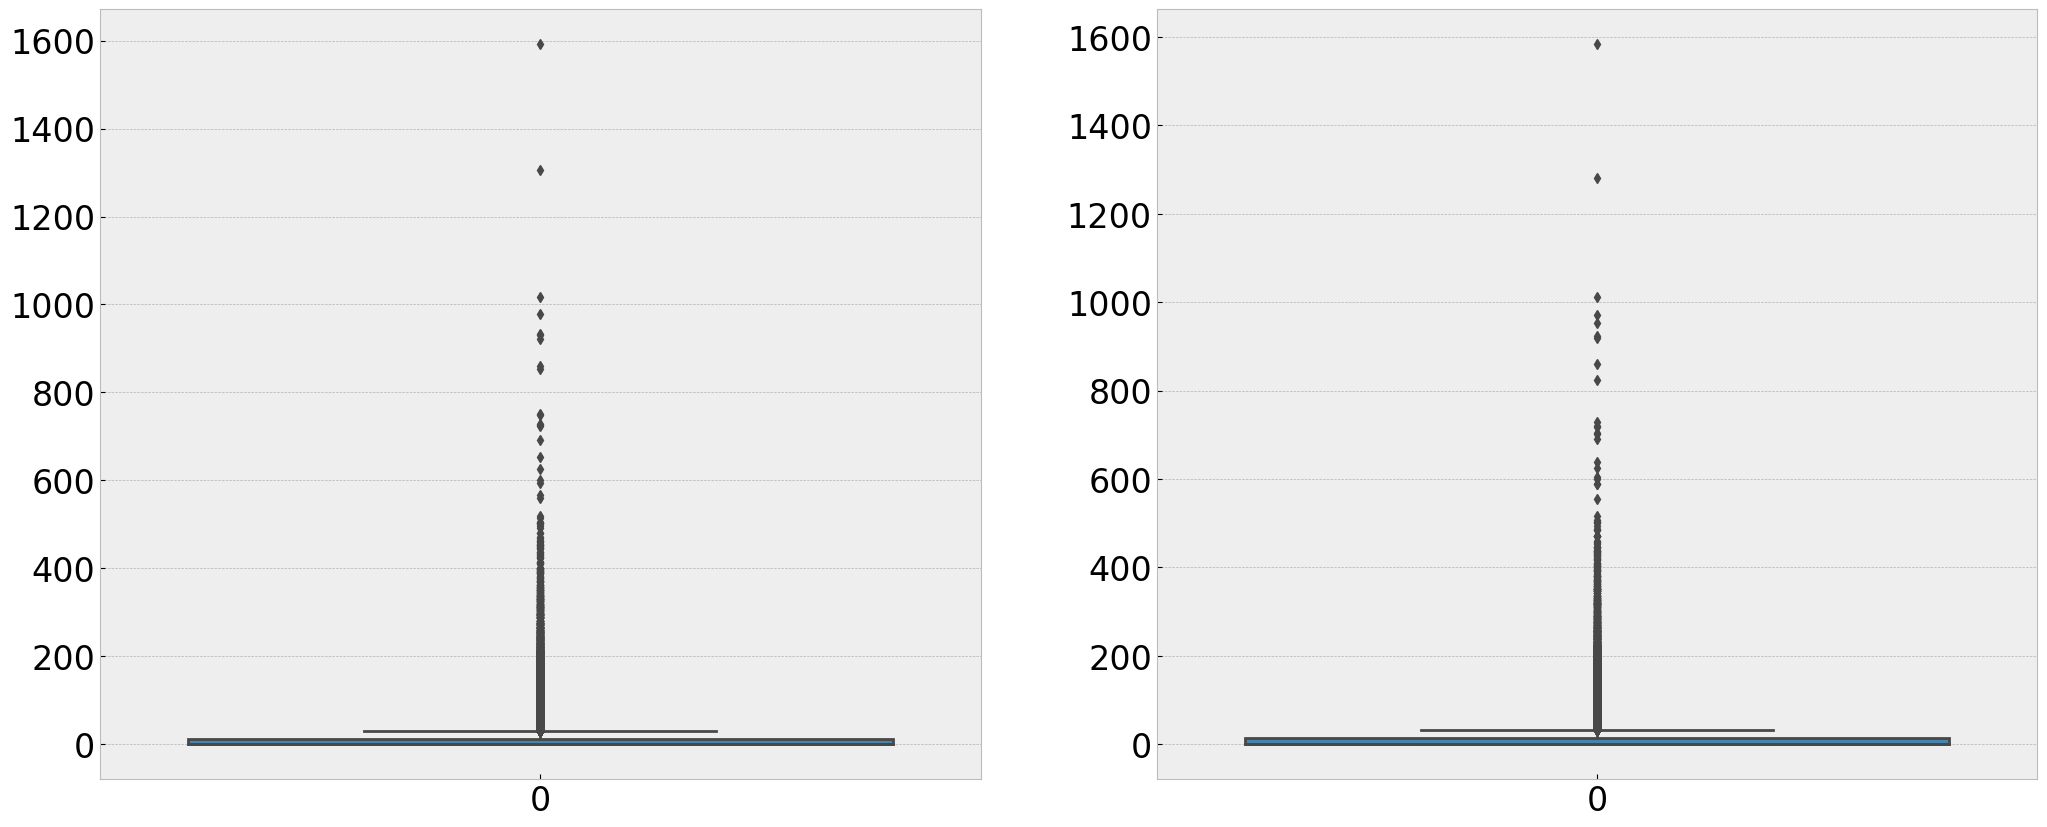

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


#numerical5 = df5.select_dtypes( include=['int64', 'float64'] )
#categorical5 = df5.select_dtypes( exclude=['int64', 'float64'] )

fig, axes = plt.subplots(1, 2)
sns.boxplot( df5['carrier_delay_in_minutes'], ax=axes[0] )
sns.boxplot( df5['delivery_delay_in_minutes'], ax=axes[1] )

# 6.0 Feature Selection

In [ ]:
df6 = df5.copy()
#data preparation
x_train_n = df6.drop(['id','satisfaction'],axis=1)
y_train_n = y_train.values


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

rf = RandomForestClassifier(n_estimators = 100)

sel = SelectFromModel( rf )

sel.fit(x_train_n, y_train_n)

SelectFromModel(estimator=RandomForestClassifier())

In [ ]:
selected_feat = x_train_n.columns[ (sel.get_support()) ]
selected_feat

Index(['type_of_purchase', 'store_size', 'instore_wifi', 'dressing_room',
       'waiting_room', 'kids_entertainment'],
      dtype='object')

In [ ]:
rf.fit(x_train_n, y_train_n)

rf.feature_importances_

array([0.0046651 , 0.03801198, 0.03347421, 0.10253601, 0.10079919,
       0.0315546 , 0.13973881, 0.01589465, 0.03578232, 0.01549634,
       0.01166964, 0.16994144, 0.05378646, 0.05184223, 0.03460313,
       0.04203188, 0.02407182, 0.02281332, 0.02338682, 0.02426878,
       0.01113371, 0.01249757])

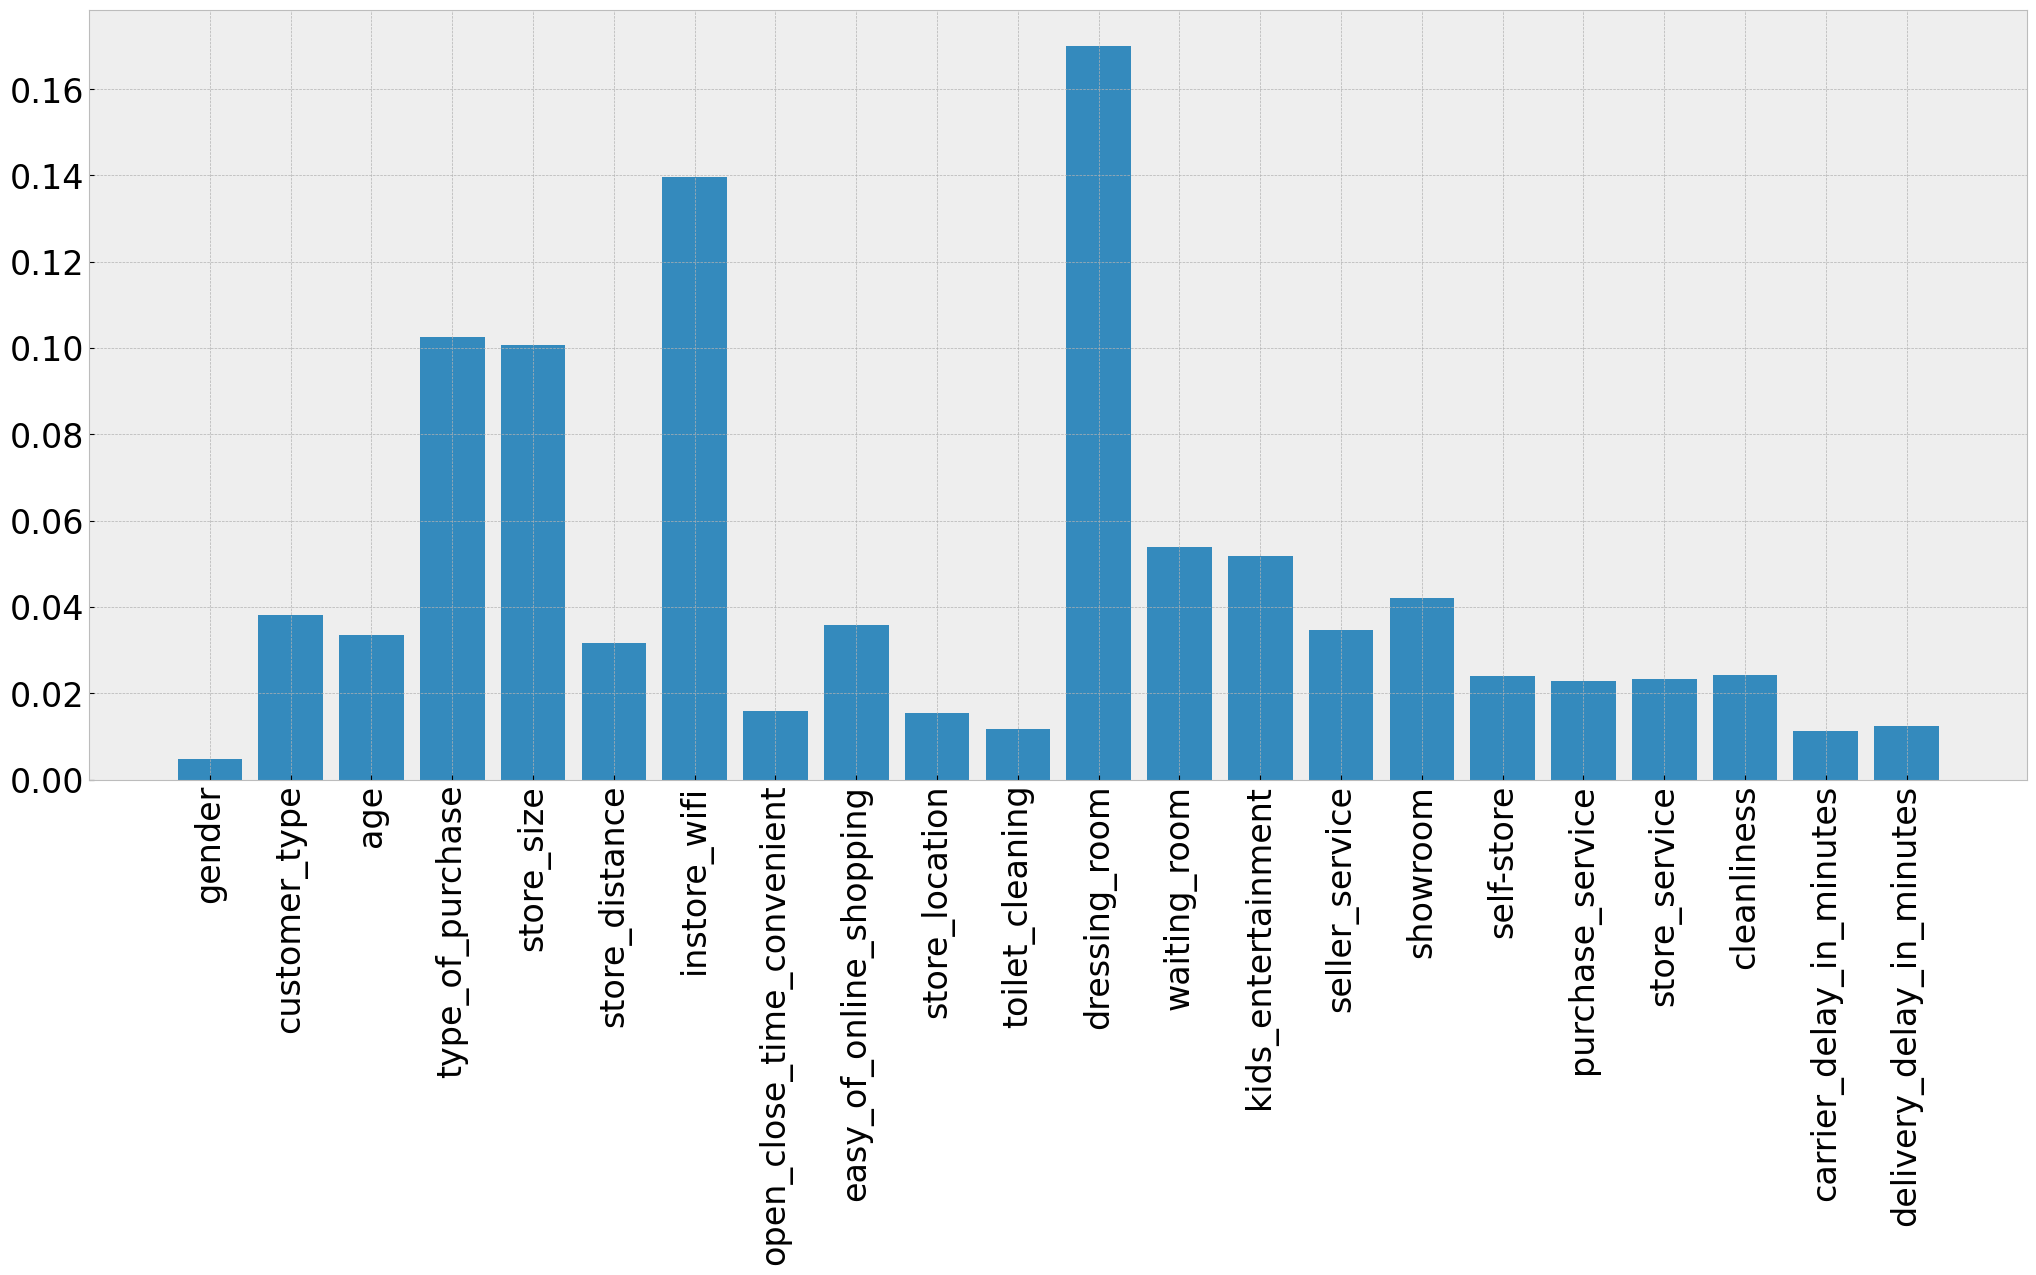

In [ ]:
features = x_train_n.columns

plt.bar( features, rf.feature_importances_ )
plt.xticks( rotation=90 );

- dressing_room 

- instore_wifi

- type_of_purchase

- store_size

In [ ]:
#Teste de Feature Selection

#model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0,n_jobs=-1)

forest.fit(x_train_n,y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking
                      feature  importance
0            type_of_purchase       0.142
0               dressing_room       0.129
0                instore_wifi       0.127
0                  store_size       0.077
0               customer_type       0.060
0          kids_entertainment       0.055
0                waiting_room       0.047
0     easy_of_online_shopping       0.043
0              seller_service       0.037
0                    showroom       0.034
0                  self-store       0.033
0                 cleanliness       0.031
0            purchase_service       0.030
0               store_service       0.027
0              store_distance       0.026
0                         age       0.021
0  open_close_time_convenient       0.019
0              store_location       0.018
0             toilet_cleaning       0.014
0   delivery_delay_in_minutes       0.011
0    carrier_delay_in_minutes       0.011
0                      gender       0.007


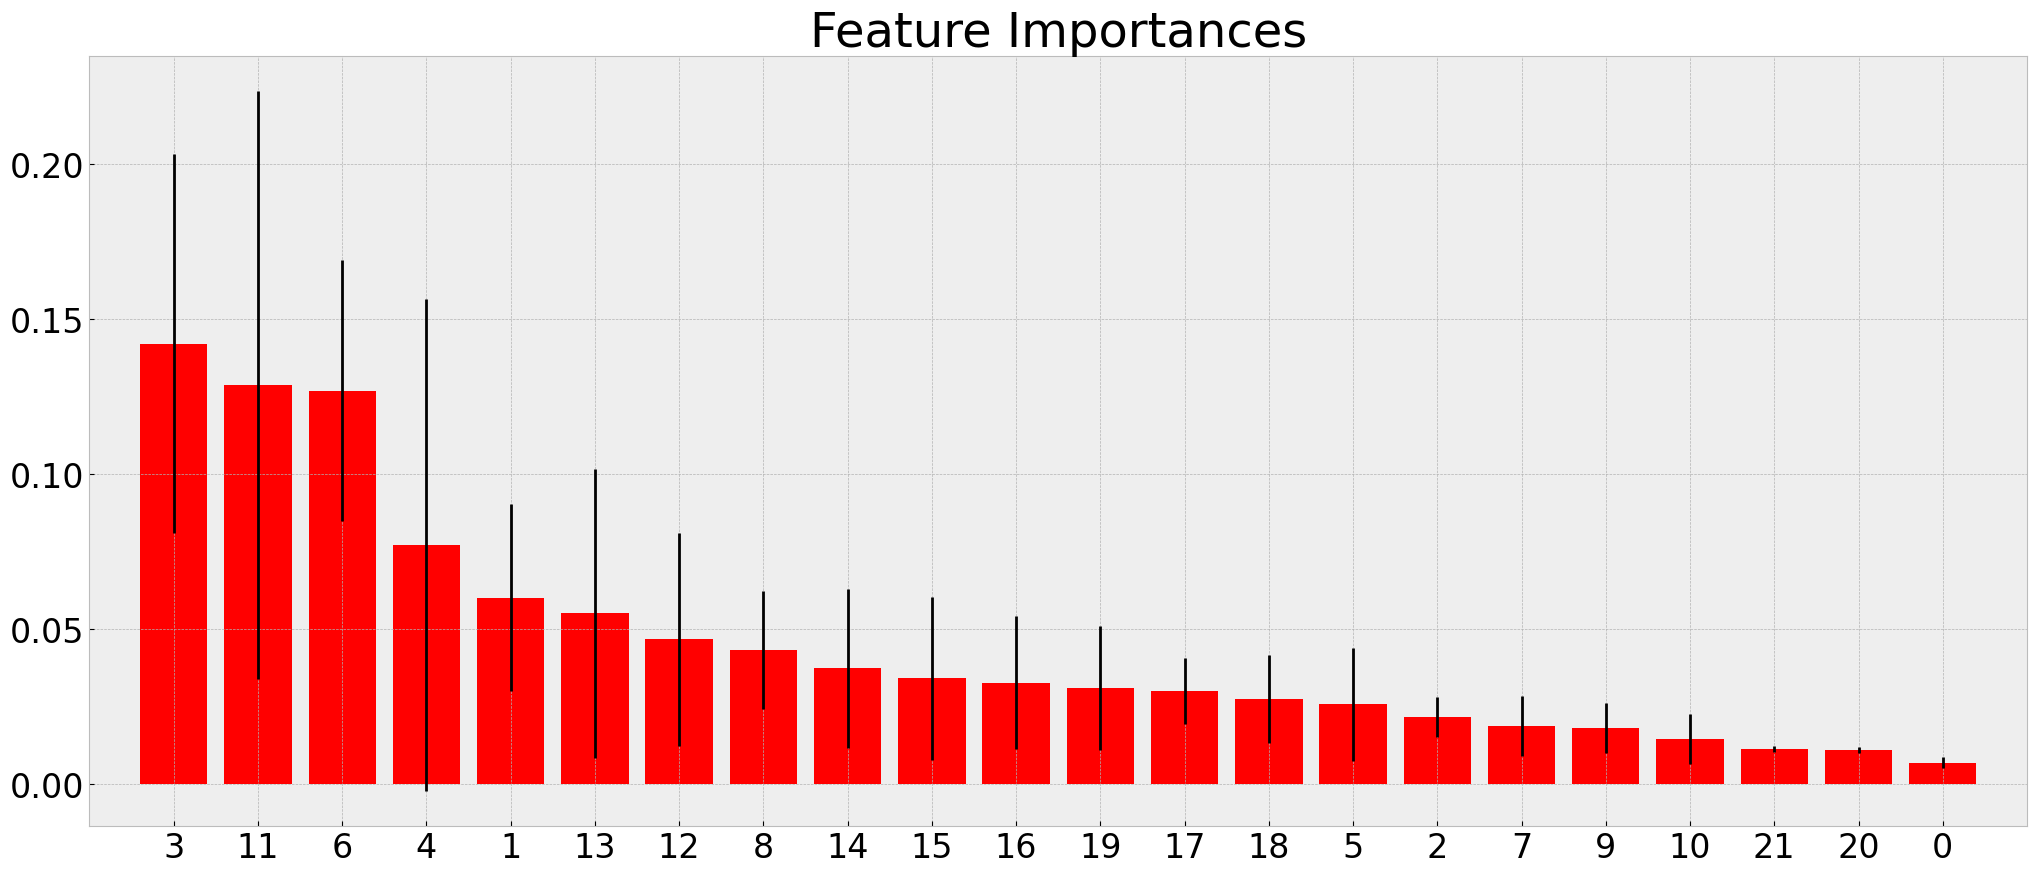

In [ ]:
importances = forest.feature_importances_ #Salva as importâncias das features
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1] #Importâncias das árvores ordenadas pelo maior valor

#print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i,j in zip(x_train_n,forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df = pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance',ascending=False))

#Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]),importances[indices],color='r',yerr=std[indices],align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

- type_of_purchase

- dressing_room

- instore_wifi

# 7.0 Machine Learning Modeling

In [ ]:
# treinamento e avaliação
df7 = df6.drop(columns=['id', 'satisfaction']).copy()
y_train = df6['satisfaction'].copy()

X_val = x_val.drop(columns=['id'])

In [ ]:
# X = df7.drop('satisfaction',axis=1)

# #Guardando a variável resposta
# Y = df7['satisfaction'].copy()

# #Separando de forma aleatória os dados que vão para o treino e os que vão para o teste
# x_train, x_validation, y_train, y_validation = ms.train_test_split(X,Y,test_size=0.20)

# #Juntando os dados de treino com a variável resposta do treino
# df7 = pd.concat([x_train,y_train],axis=1)

In [ ]:
# cols_selected = ['age', 'instore_wifi',
#        'open_close_time_convenient', 'easy_of_online_shopping',
#        'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
#        'kids_entertainment', 'seller_service', 'showroom', 'self-store',
#        'purchase_service', 'store_service', 'cleanliness']

# #Usar apenas as features selecionadas
# x_train = df7[cols_selected]
# x_val = x_validation[cols_selected]

In [ ]:
#model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7, n_jobs=-1)

#model training
knn_model.fit(df7, y_train)

y_hat_knn = knn_model.predict(x_val)

precision_micro = precision_score(y_val, y_hat_knn, average='micro')
print("Micro-Precision:", precision_micro)

# classification_rep = classification_report(y_validation, y_hat_knn)
# print("Relatório de Classificação:\n", classification_rep)


Micro-Precision: 0.7482315576728743


In [ ]:
#model definition
extra_model = en.ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1)

#model training
extra_model.fit(df7, y_train)

y_hat_et = extra_model.predict(x_val)
precision_micro = precision_score(y_val, y_hat_et, average='micro')
print("Micro-Precision:", precision_micro)

# classification_rep = classification_report(y_validation, y_hat_et)
# print("Relatório de Classificação:\n", classification_rep)

Micro-Precision: 0.9613108127616573


In [ ]:
# df_validation = pd.DataFrame(y_validation,columns=['Satisfaction'])
# df_validation['prediction'] = y_hat_et.tolist()
# df_val_comparation = pd.concat([x_validation,df_validation],axis=1)
# df_val_comparation.head()

# 8.0 Hyper Parameter Fine Tunning

In [ ]:
df8 = df7.copy()

# 9.0 Deploy to test

In [ ]:
x_test = test_data.drop(columns=['id']).copy()
y_hat_test = extra_model.predict(x_test)

In [ ]:
final_test = pd.concat([test_data, pd.Series(y_hat_test, name='Satisfaction')], axis=1)

final_test[['id', 'Satisfaction']].to_csv('/data/submission1.csv', index=False)

In [ ]:
# # predição
# #df9 = df8.copy()
# df_test = test_data.copy()

# cols_selected = ['age', 'instore_wifi',
#        'open_close_time_convenient', 'easy_of_online_shopping',
#        'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
#        'kids_entertainment', 'seller_service', 'showroom', 'self-store',
#        'purchase_service', 'store_service', 'cleanliness']
# df_test_to_ml = df_test[cols_selected]
# pred = extra_model.predict(df_test_to_ml)

# df_test['prediction'] = pred

# df_test_submission = df_test.loc[:,['id','prediction']]

In [ ]:
df_test_submission.head()

In [ ]:
df_test.columns

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dff17627-f4c4-4269-85ce-bfc293329104' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>